<a href="https://colab.research.google.com/github/divy042000/Computer-Vision/blob/main/CSE541_CV_Canny_Edge_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
from IPython.display import Image
from scipy import ndimage

In [2]:
! wget -O 'lena_color.jpg' https://i.ibb.co/sRcg28H/lena-color.jpg

--2024-01-09 09:25:45--  https://i.ibb.co/sRcg28H/lena-color.jpg
Resolving i.ibb.co (i.ibb.co)... 104.243.38.202, 104.243.38.177
Connecting to i.ibb.co (i.ibb.co)|104.243.38.202|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53357 (52K) [image/jpeg]
Saving to: ‘lena_color.jpg’

lena_color.jpg      100%[===================>]  52.11K  --.-KB/s    in 0.05s   

2024-01-09 09:25:46 (1.05 MB/s) - ‘lena_color.jpg’ saved [53357/53357]



In [3]:
Image(url='https://i.ibb.co/sRcg28H/lena-color.jpg')

# Canny Edge Detection

The Canny edge detection algorithm is composed of 5 steps:
1. Noise reduction;
2. Gradient calculation;
3. Non-maximum suppression;
4. Double threshold;
5. Edge Tracking by Hysteresis.

In [4]:
def visualize(imgs, titles):
    plt.figure(figsize=(15, 15))
    plt.gray() # show the filtered result in grayscale

    for i, img in enumerate(imgs):
        if img.shape[0] == 3:
            img = img.transpose(1,2,0)
        plt_idx = i+1
        plt.subplot(2, 2, plt_idx)
        plt.imshow(img)
        plt.title(str(titles[i]), size=20)
        plt.axis('off')

    plt.show()

def gaussian_kernel(size, sigma):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

In [5]:
image = cv2.imread('lena_color.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

## Noise Reduction

In [6]:
Image(url="http://3.bp.blogspot.com/-_eAh0snsMKo/UluusfGWg9I/AAAAAAAAAEA/ugGMpZGX5ys/s320/gaussian_formula.png")

In [7]:
g = gaussian_kernel(size=5, sigma=1)
image_gaussian = ndimage.filters.convolve(image_gray, g)


<ipython-input-7-77d56e1439a4>:2: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  image_gaussian = ndimage.filters.convolve(image_gray, g)


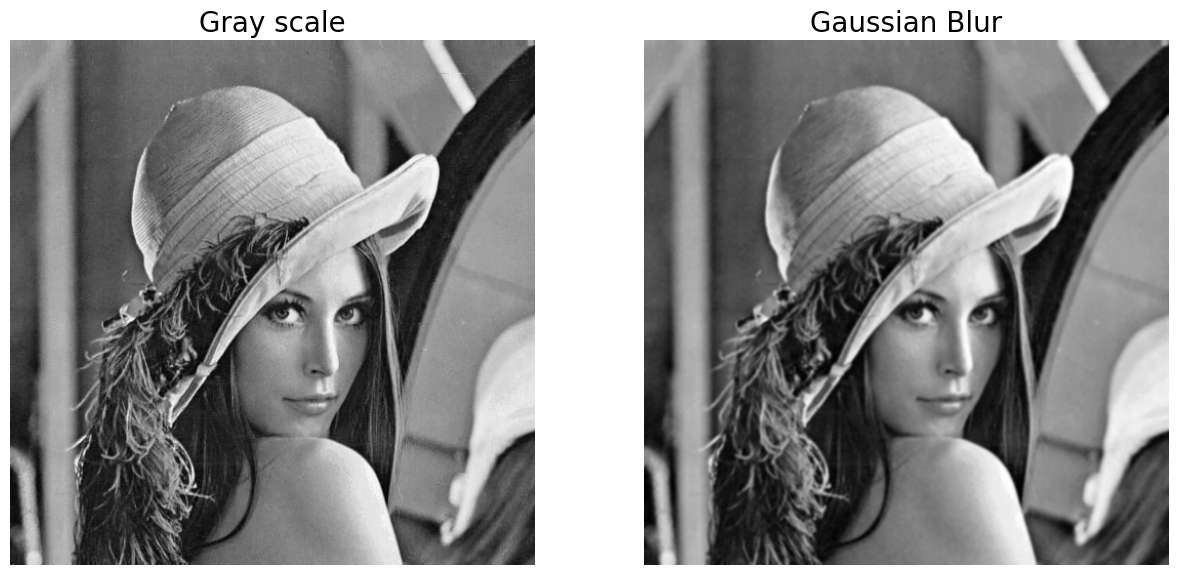

In [8]:
# display_result(image_gray, image_gaussian)
visualize([image_gray, image_gaussian], ["Gray scale", "Gaussian Blur"])

## Gradient Calculation

The Gradient calculation step detects the edge intensity and direction in both directions: horizontal (x) and vertical (y) by calculating the gradient of the image using Sobel edge detection operators (SobelX and SobelY).

In [9]:
Image(url="https://miro.medium.com/max/552/1*r5Y22pLJjDMl19tcqXseZQ.png")

Then, the magnitude G and the slope θ of the gradient are calculated as follow:

In [10]:
Image(url="https://miro.medium.com/max/294/1*HmperNZ1AXXNONDbrsJNAg.png", width=200)

In [11]:
def sobel_filters(image_gaussian):
    filter = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]) # filter for sobel edge detection

    img_sobelx = cv2.filter2D(image_gaussian, -1, filter)        # convolved with the vertical filter
    img_sobely = cv2.filter2D(image_gaussian, -1, np.flip(filter.T, axis=0)) # convolved with the horizontal filter

    image_G = np.hypot(img_sobelx, img_sobely)
    image_G = image_G / image_G.max() * 255

    theta = np.arctan2(img_sobely, img_sobelx)

    return image_G, theta

image_G, theta = sobel_filters(image_gaussian)


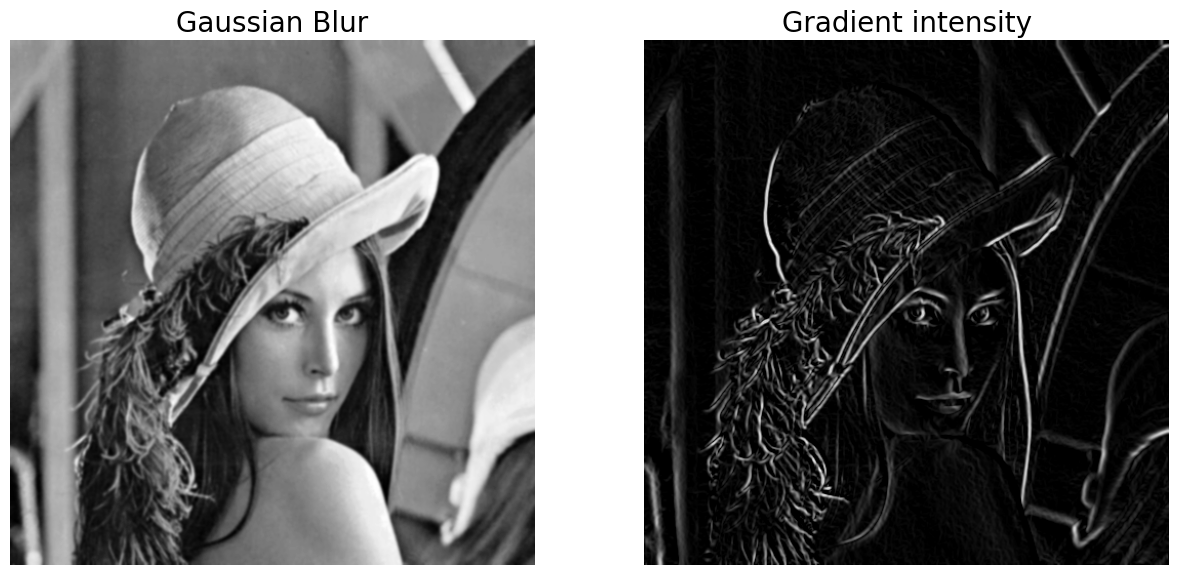

In [12]:
# display_result(image_gaussian, image_G)
visualize([image_gaussian, image_G], ["Gaussian Blur", "Gradient intensity"])


## Non-Maximum Suppression

the final image should have thin edges.

Convert thick edges to thin edges

In [13]:
Image(url="https://miro.medium.com/max/1094/1*CWrXNSbe7s4qSFr5vylyvQ.png")

In [14]:
Image(url="https://miro.medium.com/max/804/1*K-gnZg4_VPk57Xs0XflIrg.png")

In [15]:
def non_max_suppression(image_G, theta):
    M, N = image_G.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = theta * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255

                #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = image_G[i, j+1]
                    r = image_G[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = image_G[i+1, j-1]
                    r = image_G[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = image_G[i+1, j]
                    r = image_G[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = image_G[i-1, j-1]
                    r = image_G[i+1, j+1]

                if (image_G[i,j] >= q) and (image_G[i,j] >= r):
                    Z[i,j] = image_G[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    return Z

Z = non_max_suppression(image_G, theta)

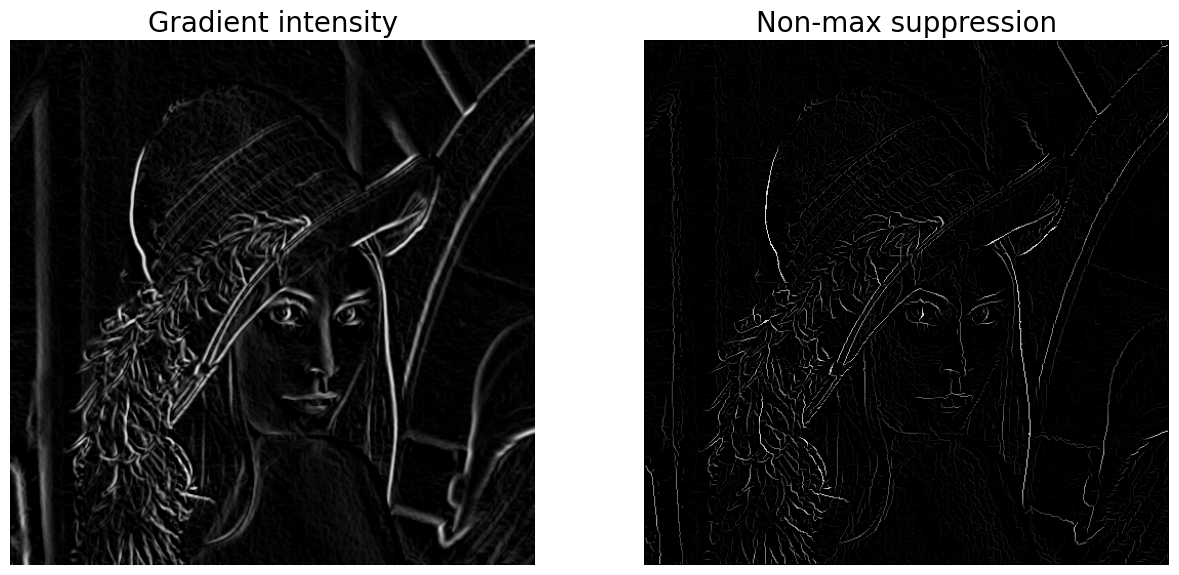

In [16]:
visualize([image_G, Z], ["Gradient intensity", "Non-max suppression"])

## Find thresholds

Aims at identifying 3 kinds of pixels: strong, weak, and non-relevant

> Strong pixels are pixels that have an intensity so high that we are sure they contribute to the final edge.

> Weak pixels are pixels that have an intensity value that is not enough to be considered as strong ones, but yet not small enough to be considered as non-relevant for the edge detection.

> Other pixels are considered as non-relevant for the edge.



In [17]:
def threshold(img, lowThresholdRatio=0.08, highThresholdRatio=0.2):
# def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):

    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;

    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)

    weak = np.int32(25)
    strong = np.int32(255)

    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)

    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    return (res, weak, strong)

image_res, weak_threshold, strong_threshold = threshold(Z)


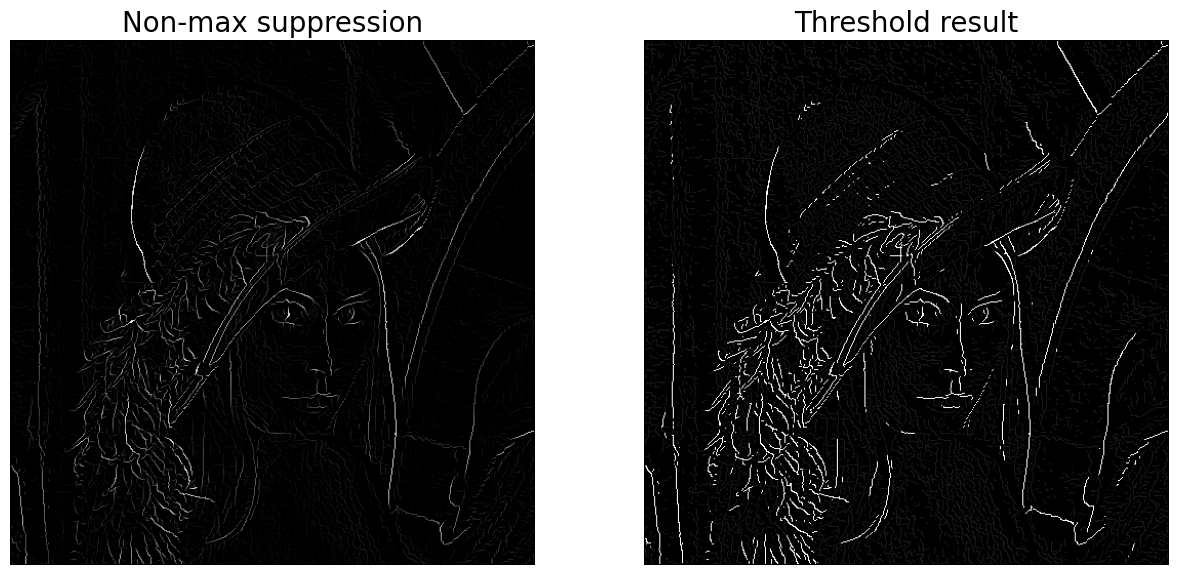

In [18]:
visualize([Z, image_res],["Non-max suppression", "Threshold result"])

## Edge Tracking by Hysteresis

Based on the threshold results, the hysteresis consists of transforming weak pixels into strong ones, if and only if at least one of the pixels around the one being processed is a strong one

In [19]:
Image(url="https://miro.medium.com/max/1350/1*jnqS5hbRwAmU-sgK552Mgg.png")

In [20]:
def hysteresis(img, weak, strong=255):
    M, N = img.shape
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

image_canny = hysteresis(image_res, weak_threshold, strong=strong_threshold)


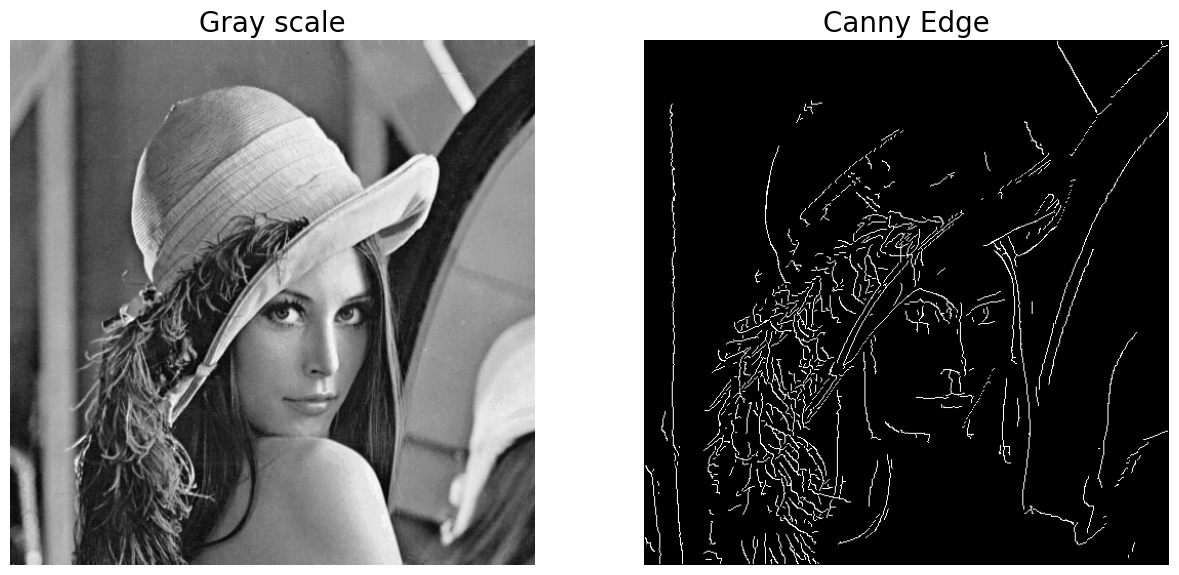

In [21]:
visualize([image_gray, image_canny], ["Gray scale", "Canny Edge"])